In [1]:
"""
Master/Slave Serialized Communication
Slaves send bit to master
Master then clears channel
Master has to recieve 2 * n communications because channel can start "on"

Solve using a 3D markov Chain
"""

import numpy as np
indexes = []
for switch in [0, 1]:
    for num_zeros in range(0,100):
        for num_ones in range(0, 100 - num_zeros):
            num_twos = 99 - num_zeros - num_ones
            key = (switch, num_zeros, num_ones, num_twos)
            indexes.append(key)
            
def update_graph_master(switch, num_zeros, num_ones, num_twos, g, index_lookup):
    key = (switch, num_zeros, num_ones, num_twos)
    p = 1.0/100.0
    next_state = (0, num_zeros, num_ones, num_twos)
    from_index, to_index = index_lookup[key], index_lookup[next_state]
    g[from_index][to_index] += p
    
def update_graph_zero(switch, num_zeros, num_ones, num_twos, g, index_lookup):
    if num_zeros == 0:
        return
    key = (switch, num_zeros, num_ones, num_twos)
    p = num_zeros/100.0
    if switch == 0:
        next_state = (1, num_zeros-1, num_ones+1, num_twos)
    else:
        next_state = key
    from_index, to_index = index_lookup[key], index_lookup[next_state]
    g[from_index][to_index] += p
    
def update_graph_one(switch, num_zeros, num_ones, num_twos, g, index_lookup):
    if num_ones == 0:
        return
    key = (switch, num_zeros, num_ones, num_twos)
    p = num_ones/100.0
    if switch == 0:
        next_state = (1, num_zeros, num_ones-1, num_twos+1)
    else:
        next_state = key
    from_index, to_index = index_lookup[key], index_lookup[next_state]
    g[from_index][to_index] += p
    
def update_graph_two(switch, num_zeros, num_ones, num_twos, g, index_lookup):
    if num_twos == 0:
        return
    key = (switch, num_zeros, num_ones, num_twos)
    p = num_twos/100.0
    next_state = key
    from_index, to_index = index_lookup[key], index_lookup[next_state]
    g[from_index][to_index] += p
    
index_lookup = {v:i for i, v in enumerate(indexes)}            
g = np.zeros(shape=(len(indexes), len(indexes)))

for switch in [0, 1]:
    for num_zeros in range(0,100):
        for num_ones in range(0, 100 - num_zeros):
            num_twos = 99 - num_zeros - num_ones
            assert num_zeros + num_ones + num_twos == 99
            key = (switch, num_zeros, num_ones, num_twos)
            update_graph_master(switch, num_zeros, num_ones, num_twos, g, index_lookup)
            # Pick a Zero
            update_graph_zero(switch, num_zeros, num_ones, num_twos, g, index_lookup)
            # Pick a One
            update_graph_one(switch, num_zeros, num_ones, num_twos, g, index_lookup)
            # Pick a Two
            update_graph_two(switch, num_zeros, num_ones, num_twos, g, index_lookup)
            

In [2]:
import numpy.linalg
def ev(g, start, stop):
    """
    Get expected value to go from start to stop in a transition matrix g
    """
    g2 = np.delete(g, stop, axis=0)
    g2 = np.delete(g2, stop, axis=1)
    eye = np.eye(len(g2))
    g2 = eye - g2
    if start > stop:
        start -= 1
    try:
        return numpy.linalg.solve(g2, np.ones((len(g2),)))[start]
    except:
        return numpy.linalg.lstsq(g2, np.ones((len(g2),)))[0][start]

In [3]:
# Average the Expected values of the two scenarios
start, stop = index_lookup[(0, 99, 0, 0)], index_lookup[(0, 0, 0, 99)]
ex1 = ev(g, start, stop)
start, stop = index_lookup[(1, 99, 0, 0)], index_lookup[(0, 0, 1, 98)]
ex2 = ev(g, start, stop)
ex = (ex1 + ex2) * 0.5
print("Expected Value = %s" % ex)

(10099, 10099)
(10099, 10099)
Expected Value = 20477.6630505


In [4]:
# Lets run a Monte Carlo To Ensure I'm not Taking Crazy Pills
import random
def randbool():
    return random.randint(0,1)==0
def simulate():
    people = [0] * 100
    switches = [randbool(), randbool()]
    turns = 0
    count = 0
    while count < 198:
        prisoner = random.randint(0,99)
        if prisoner == 0:
            if switches[0] == True:
                switches[0] = False
                count += 1
            else:
                switches[1] = not switches[1]
        else:
            if switches[0] == False and people[prisoner] < 2:
                people[prisoner] += 1
                switches[0] = True
            else:
                switches[1] = not switches[1]
        turns += 1
    return turns

In [5]:
results = [simulate() for x in range(10000)]
print(np.mean(results))

20464.273


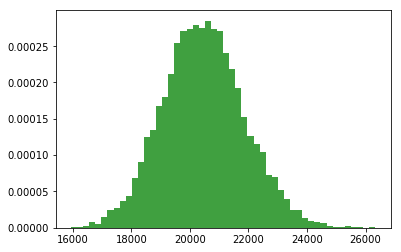

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
n, bins, patches = plt.hist(results, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()